In [14]:
# objective: generate the particle size structure for the CMIP6 models
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob,os,subprocess
from glob import glob
import IPython.display as display
%matplotlib inline
from datetime import datetime as dt
import seaborn as sns
import scipy as sp

In [2]:
#import data and create dictionary
# create a dictionary with the datasets
file_list = glob('/work/m1c/CMIP6_biome_PSS_data/*.nc')

file_list_biovol = glob('/work/m1c/CMIP6_biome_PSS_data/*biovolume.nc')
file_list_biovol_zoo_only = [x for x in file_list_biovol if 'zoo-only' in x]
file_list_biovol_phyto_only = [x for x in file_list_biovol if 'phyto-only' in x]
file_list_biovol = list(set(file_list_biovol).difference(file_list_biovol_zoo_only+file_list_biovol_phyto_only))

file_list_climatology = glob('/work/m1c/CMIP6_biome_PSS_data/*climatology_all*')

file_list_gCarbon = list(set(file_list).difference(file_list_biovol+file_list_climatology))

In [3]:
file_list_biovol

['/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_hist_biovolume.nc']

In [4]:
#open the files, and modify time labels to months
model_list =['CESM','CMCC','CNRM','GFDL','GISS', 'IPSL','UKESM'] #['CESM', 'CMCC','CNRM','GFDL', 'GISS','IPSL','UKESM']
ds_dict = {}
ds_dict['hist']={}
ds_dict['ssp5']={}

for e in ['hist', 'ssp5']:
    for m in model_list:
        model_path = [x for x in file_list_biovol if e in x and m in x]
        ds_dict[e][m]= xr.open_mfdataset(model_path).groupby('time.month').mean(dim='time')
        #print(m)
        #print (ds_dict[e][m])
        if e == 'hist':
            vars = [ 'betas_hist', 'intercept_hist', 'total_biovolume_hist', 'chl']
        elif e == 'ssp5':
            vars = [ 'betas_ssp5', 'intercept_ssp5', 'total_biovolume_ssp5', 'chl']
            
        for var in vars: # biomass arrays here
            SH_subset = ds_dict[e][m][var].where(ds_dict[e][m][var].lat < 0,drop=True).values # selecting southern hemisphere
            SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
            full_field = ds_dict[e][m][var].values #select biomass values for each of the phytoplankton groups
            full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
            #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
            svar = var #+ '_shift' # 
            ds_dict[e][m][svar] = xr.DataArray(full_field, dims=ds_dict[e][m][var].dims, coords=ds_dict[e][m][var].coords)

CESM
<xarray.Dataset>
Dimensions:               (month: 12, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 0.08765 0.144 ... 3.286e+09
  * month                 (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    biomes                (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NB                    (month, biovol_um3, lat, lon) float64 dask.array<chunksize=(1, 50, 180, 360), meta=np.ndarray>
    total_biovolume_hist  (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    betas_hist            (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    intercept_hist        (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    R2_hist               (month, lat,

In [5]:
ds_dict['hist']['CMCC']

<xarray.Dataset>
Dimensions:               (month: 12, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.939 10.66 ... 1.697e+13
  * month                 (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    biomes                (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    betas_hist            (month, lat, lon) float64 nan nan ... -1.076 -1.076
    intercept_hist        (month, lat, lon) float64 nan nan ... 1.805e+12
    R2_hist               (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    RMSE_hist             (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NB                    (month, biovol_um3, lat, lon) float64 dask.array<chunksize=(1, 50, 180, 360), meta=np.ndarray>
    total_biovolume_hist  (month, lat, lon) float64 nan nan ... 8.642e+12
    chl                   (month, lat, lon) float64 5.438e-07 5.436e-07 ... nan
    phymisc               (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    phydiat               (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zmicro                (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zmeso                 (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

In [4]:
def assign_seasons(month):
    if month in ['12.0', '1.0', '2.0']:
        return 'Winter'
    elif month in ['3.0', '4.0', '5.0']:
        return 'Spring'
    elif month in ['6.0', '7.0', '8.0']:
        return 'Summer'
    elif month in ['9.0', '10.0', '11.0']:
        return 'Fall'
    
# open files, average by 'select', and save again.
def average_files(df):
    #print(df.head())
    df =df.astype(dict(zip(['month'],[str]))).groupby(['source', 'month', 'experiment', 'biomes']).apply(lambda x: pd.Series({

                                                                    'slope':np.nanmean(x.slope),
                                                                    'intercept':np.nanmean(x.intercept),
                                                                    'total_biovolume':np.nanmean(x.total_biovolume),
                                                                    'chl':np.nanmean(x.chl)})).reset_index()
    return df    

In [7]:
all_df = pd.DataFrame()
for e in ['hist', 'ssp5']:
    for m in model_list:
        test_df = ds_dict[e][m].to_dataframe()
        test_df=test_df.dropna().reset_index()
        test_df=test_df.drop_duplicates().reset_index(drop=True)
        if e == 'hist':
            vars = [ 'betas_hist', 'intercept_hist','total_biovolume_hist', 'chl']
        elif e == 'ssp5':
            vars = [ 'betas_ssp5', 'intercept_ssp5',  'total_biovolume_ssp5', 'chl']
        test_df = test_df[['lat', 'lon', 'month', 'biomes']+vars]
        if e == 'hist':
            test_df.rename(columns={'betas_hist':'slope', 'intercept_hist':'intercept', 'total_biovolume_hist':'total_biovolume'}, inplace=True)
            test_df['experiment'] = 'hist'
        elif e == 'ssp5':
            test_df.rename(columns={'betas_ssp5':'slope', 'intercept_ssp5':'intercept', 'total_biovolume_ssp5':'total_biovolume'}, inplace=True)
            test_df['experiment'] = 'ssp5'
        test_df['source'] = m
        test_df['month'] = test_df['month'].astype(str)+'.0'#.str.zfill(2)
        test_df['season'] = test_df['month'].apply(assign_seasons)
        test_df['biomes'] = test_df['biomes'].astype(str)
        test_df = test_df.replace({'biomes':{'1.0':'LC','2.0':'HCSS','3.0':'HCPS'}})
        all_df= pd.concat([all_df, test_df])
all_df=all_df.drop_duplicates().reset_index(drop=True)     
all_df

lat    lon month biomes     slope     intercept  total_biovolume  \
0       -77.5 -179.5   1.0   HCSS -0.907265  1.448721e+11     3.604478e+12   
1       -77.5 -178.5   1.0   HCSS -0.909153  1.584194e+11     3.791176e+12   
2       -77.5 -177.5   1.0   HCSS -0.911068  1.739923e+11     3.999223e+12   
3       -77.5 -176.5   1.0   HCSS -0.912826  1.916664e+11     4.241474e+12   
4       -77.5 -175.5   1.0   HCSS -0.914441  2.114271e+11     4.516142e+12   
...       ...    ...   ...    ...       ...           ...              ...   
4184095  77.5  177.5  12.0   HCSS -1.151904  7.503153e+12     3.081296e+12   
4184096  77.5  178.5  12.0   HCSS -1.152228  7.533209e+12     3.073716e+12   
4184097  77.5  179.5  12.0   HCSS -1.152508  7.562250e+12     3.068633e+12   
4184098  78.5 -165.5  12.0   HCSS -1.152636  7.479914e+12     2.990052e+12   
4184099  78.5 -164.5  12.0   HCSS -1.152233  7.549439e+12     3.034412e+12   

                  chl experiment source  season  
0        1.705314e-06       hist   CESM  Winter  
1        1.705523e-06       hist   CESM  Winter  
2        1.703174e-06       hist   CESM  Winter  
3        1.698172e-06       hist   CESM  Winter  
4        1.689678e-06       hist   CESM  Winter  
...               ...        ...    ...     ...  
4184095  2.324523e-08       ssp5  UKESM  Winter  
4184096  2.914845e-08       ssp5  UKESM  Winter  
4184097  3.563528e-08       ssp5  UKESM  Winter  
4184098  8.538418e-08       ssp5  UKESM  Winter  
4184099  1.040437e-07       ssp5  UKESM  Winter  

[4184100 rows x 11 columns]

In [8]:
all_df.to_csv('/work/m1c/CMIP6_biome_PSS_data/CMIP6_data_slope_chl_biovolume.csv', sep= ',', index = False)


In [2]:
df = pd.read_csv('/Users/mc4214/CMIP6_biome_PSS_data/CMIP6_data_slope_chl_biovolume.csv', sep= ',', header=[0])

In [3]:
# convert to mg/m^3
df['chl']=np.log10(df['chl']*1e6)

In [5]:
df_avg=average_files(df)
df_avg

source month experiment biomes     slope     intercept  total_biovolume  \
0     CESM   1.0       hist   HCPS -1.045578  2.259749e+13     3.475697e+13   
1     CESM   1.0       hist   HCSS -1.024891  9.915243e+12     1.523537e+13   
2     CESM   1.0       hist     LC -1.079999  2.327989e+13     2.921119e+13   
3     CESM   1.0       ssp5   HCPS -1.032492  2.055844e+13     3.227535e+13   
4     CESM   1.0       ssp5   HCSS -1.006246  8.669730e+12     1.427145e+13   
..     ...   ...        ...    ...       ...           ...              ...   
499  UKESM   9.0       hist   HCSS -1.153157  1.402819e+14     6.124621e+13   
500  UKESM   9.0       hist     LC -1.274967  1.907755e+14     1.623718e+13   
501  UKESM   9.0       ssp5   HCPS -1.170869  1.621267e+14     5.747363e+13   
502  UKESM   9.0       ssp5   HCSS -1.168657  1.454800e+14     5.444105e+13   
503  UKESM   9.0       ssp5     LC -1.302300  2.169325e+14     1.403066e+13   

          chl  
0   -0.871837  
1   -0.513654  
2   -1.117113  
3   -0.887253  
4   -0.732455  
..        ...  
499 -0.713430  
500 -0.903653  
501 -0.782880  
502 -0.690162  
503 -1.064287  

[504 rows x 8 columns]

In [6]:
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.' ,'u.']

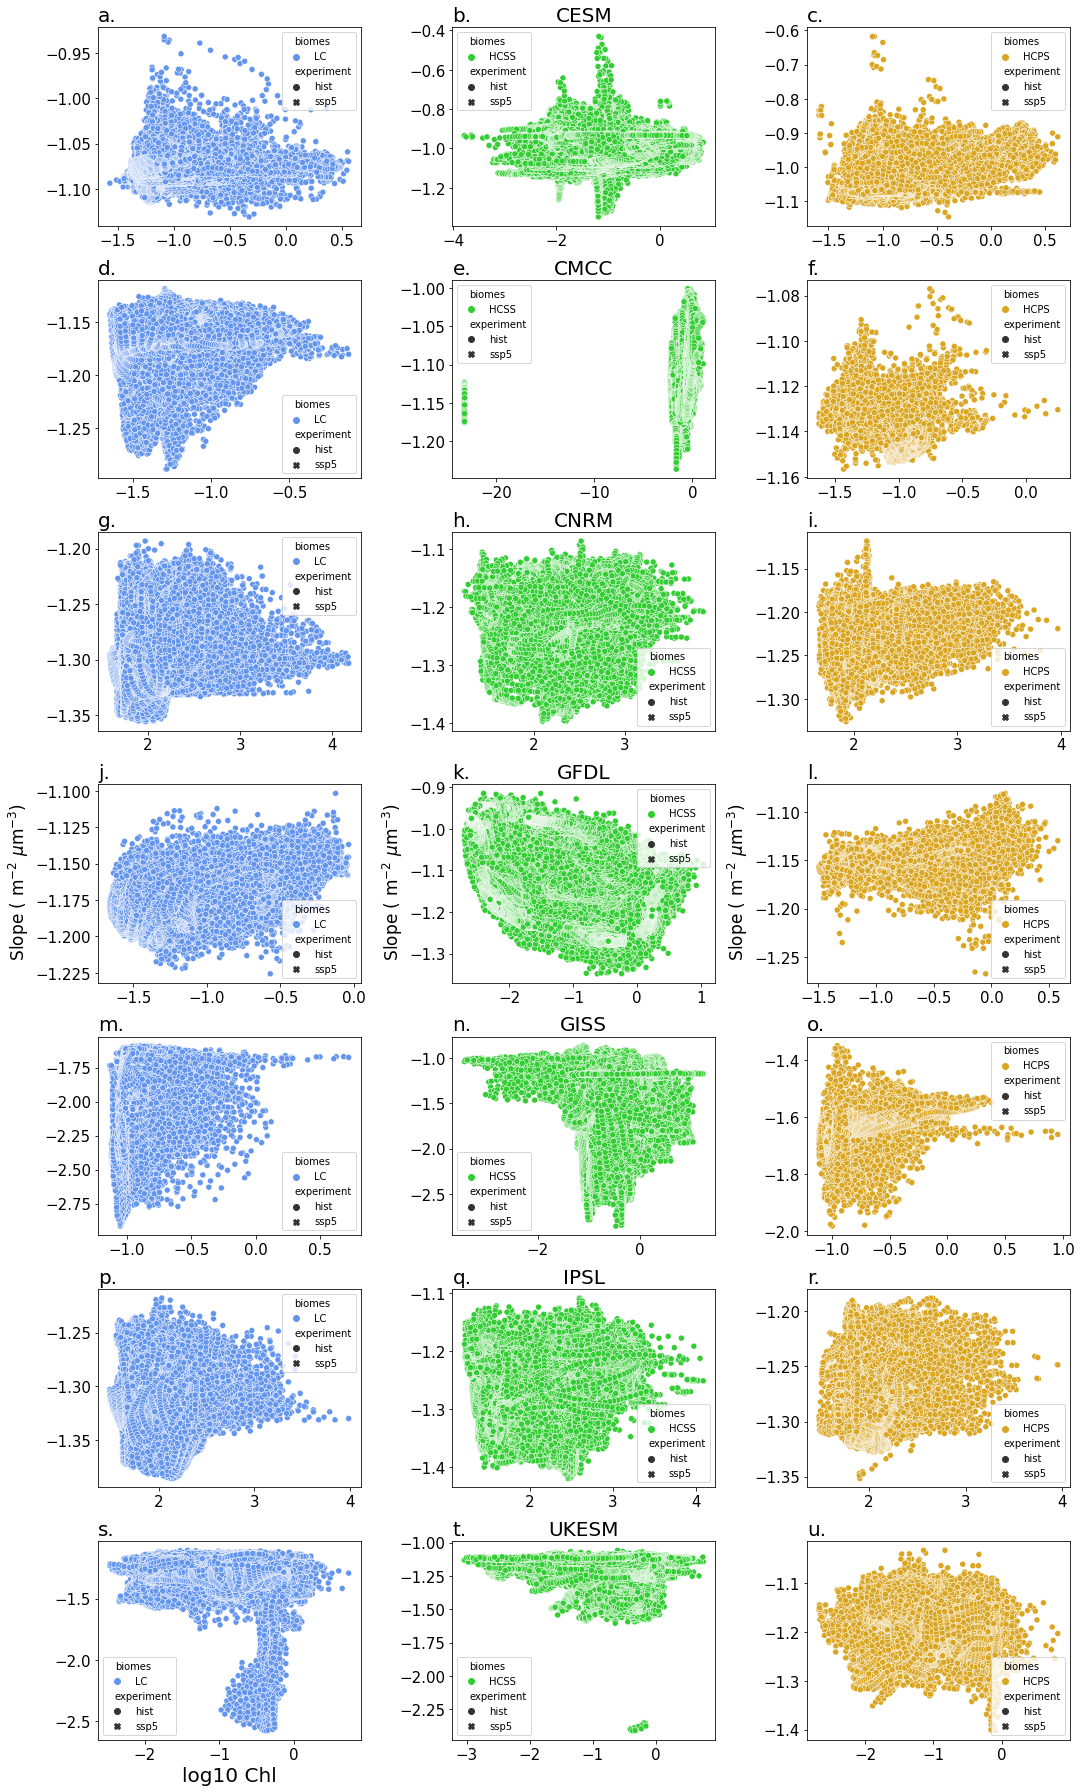

In [7]:
from matplotlib.ticker import MaxNLocator
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
palette = dict(LC= 'cornflowerblue', HCSS= 'limegreen', HCPS= 'goldenrod')
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
variables = ['slope']
ind=0
for r, m in enumerate(model_list):
    #print(r)
    for c, biome in enumerate(['LC', 'HCSS', 'HCPS']):
        #print(c)
        ind +=1
        ax_n = axs[r,c]
        clim=sns.scatterplot(ax = ax_n,x = 'chl', y='slope', hue = 'biomes',palette=palette, style = 'experiment', alpha=0.1, style_order=['hist','ssp5'], data=df[(df['source']== m) & (df['biomes']== biome) & (df['experiment']== 'hist')])
        ax_n.tick_params(axis='both', which='major', labelsize=15)
        ax_n.set_title(letters[ind-1], loc='left', fontsize=20)
        #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if c == 1:
            ax_n.set_title(m, fontsize=20)
        else:
            ax_n.set_title('')
        if r ==6 and c ==1:
            ax_n.set_xlabel('$log_{10}$ Chl (mg m$^{-3}$)', fontsize=20)
        else:
            ax_n.set_xlabel('', fontsize=20)

        if r ==3:
            ax_n.set_ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
        else:
            ax_n.set_ylabel('')
       

    


        
            
plt.tight_layout()
plt.savefig('/Users/mc4214/Documents/CMIP6_PSS_paper/figures/paper/newest/final_for_paper/figures_revised_Charlie/July_revision/fig_chl_slopes_all_cells.pdf', dpi=300)

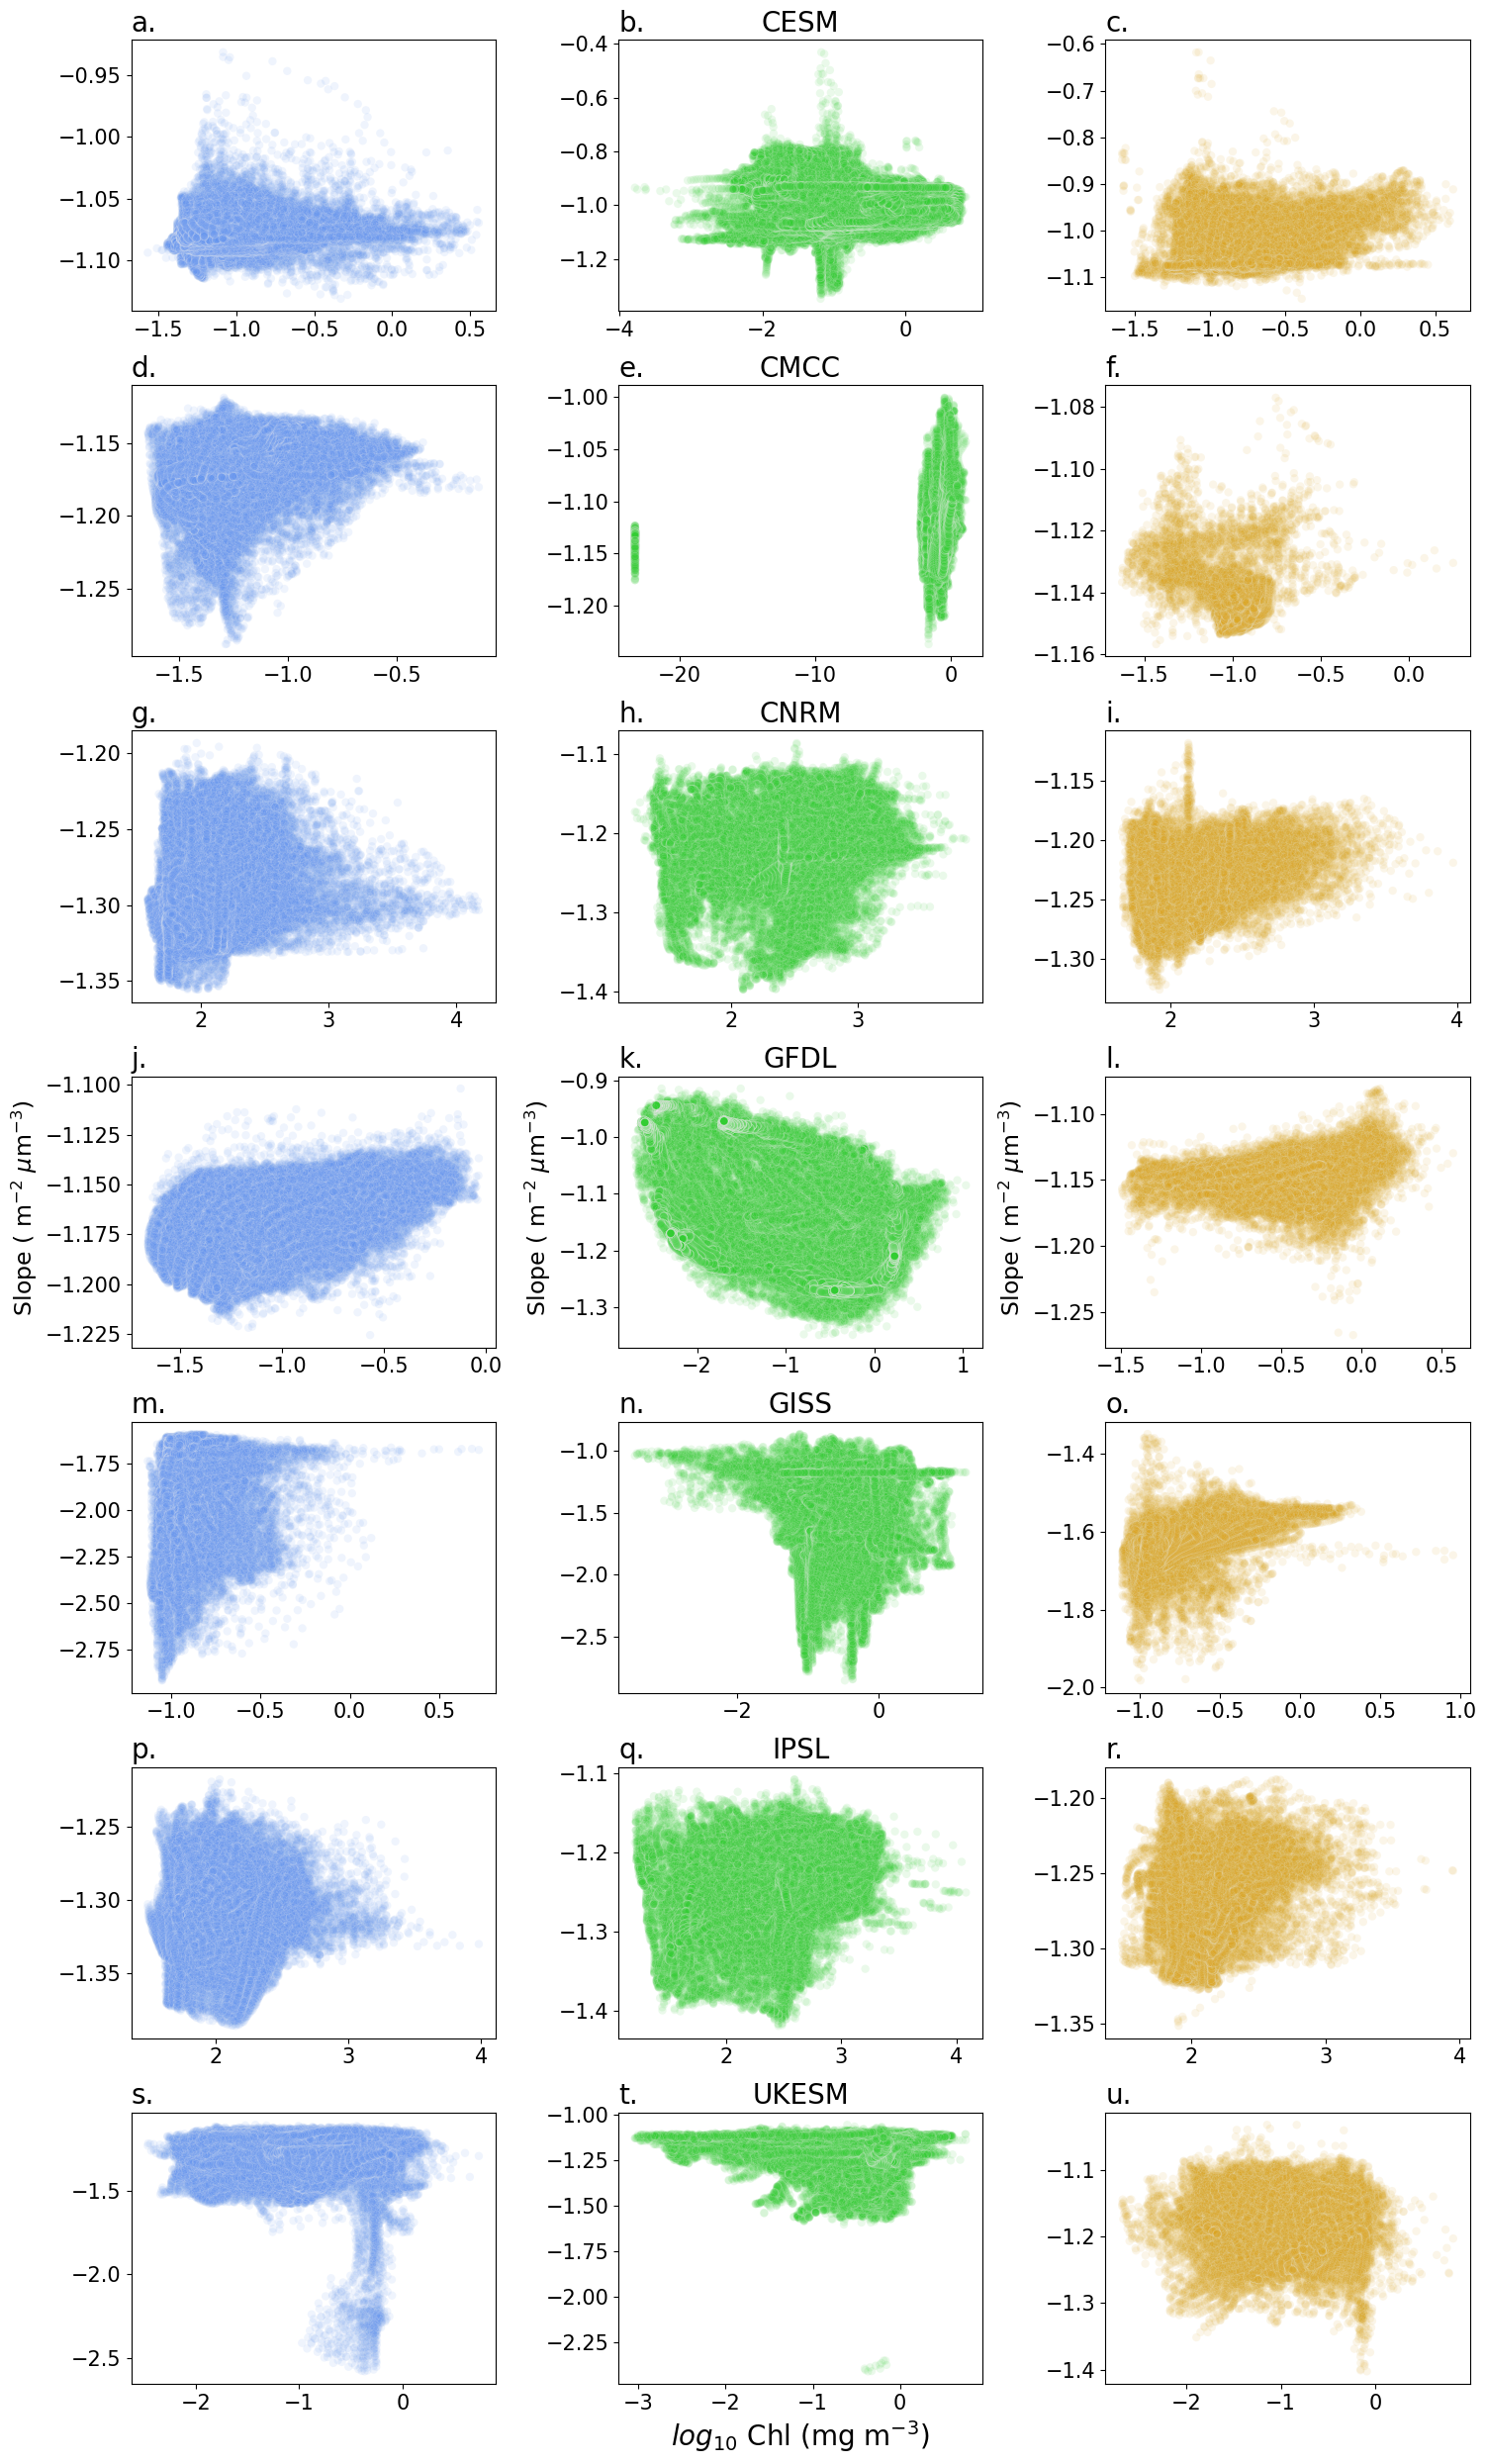

In [8]:
from matplotlib.ticker import MaxNLocator
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
palette = dict(LC= 'cornflowerblue', HCSS= 'limegreen', HCPS= 'goldenrod')
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
variables = ['slope']
ind=0
for r, m in enumerate(model_list):
    #print(r)
    for c, biome in enumerate(['LC', 'HCSS', 'HCPS']):
        #print(c)
        ind +=1
        ax_n = axs[r,c]
        clim=sns.scatterplot(ax = ax_n,x = 'chl', y='slope', hue = 'biomes',palette=palette, alpha=0.1, data=df[(df['source']== m) & (df['biomes']== biome) & (df['experiment']== 'hist')])
        ax_n.tick_params(axis='both', which='major', labelsize=15)
        ax_n.set_title(letters[ind-1], loc='left', fontsize=20)
        ax_n.get_legend().remove()
        #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if c == 1:
            ax_n.set_title(m, fontsize=20)
        else:
            ax_n.set_title('')
        if r ==6 and c ==1:
            ax_n.set_xlabel('$log_{10}$ Chl (mg m$^{-3}$)', fontsize=20)
        else:
            ax_n.set_xlabel('', fontsize=20)

        if r ==3:
            ax_n.set_ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 17)
        else:
            ax_n.set_ylabel('')
       

    


        
            
plt.tight_layout()
plt.savefig('/Users/mc4214/Documents/CMIP6_PSS_paper/figures/paper/newest/final_for_paper/figures_revised_Charlie/July_revision/fig_chl_slopes_all_cells_hist_only.pdf', dpi=300)

In [28]:
#CESM regression
CESM_reg=sp.stats.linregress(x=df[(df['source']== 'CESM') & (df['experiment']== 'hist')].dropna().chl, y=df[(df['source']== 'CESM') & (df['experiment']== 'hist')].dropna().slope)
CESM_reg

LinregressResult(slope=0.005683901207670568, intercept=-1.0351379615199503, rvalue=0.04140802966234988, pvalue=1.5583259111687967e-101, stderr=0.0002655777232320523, intercept_stderr=0.0002675350790749936)

In [21]:
#CMCC regression
CMCC_reg=sp.stats.linregress(x=df[(df['source']== 'CMCC') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'CMCC') & (df['experiment']== 'hist')].slope)
CMCC_reg

LinregressResult(slope=0.0033947446390056816, intercept=-1.1452055715591904, rvalue=0.14725991071897318, pvalue=0.0, stderr=4.4311951722657195e-05, intercept_stderr=7.281330076665734e-05)

In [29]:
#CNRM regression
CNRM_reg=sp.stats.linregress(x=df[(df['source']== 'CNRM') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'CNRM') & (df['experiment']== 'hist')].slope)
CNRM_reg

LinregressResult(slope=0.04977458428428133, intercept=-1.3661530310536036, rvalue=0.413250736864468, pvalue=0.0, stderr=0.0002135732373460446, intercept_stderr=0.0004908146720347231)

In [30]:
#GFDL regression
GFDL_reg=sp.stats.linregress(x=df[(df['source']== 'GFDL') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'GFDL') & (df['experiment']== 'hist')].slope)
GFDL_reg

LinregressResult(slope=-0.03370343304294225, intercept=-1.169964844552676, rvalue=-0.33740562377572797, pvalue=0.0, stderr=0.00013427849531582068, intercept_stderr=0.0001270079647526174)

In [31]:
#GISS regression
GISS_reg=sp.stats.linregress(x=df[(df['source']== 'GISS') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'GISS') & (df['experiment']== 'hist')].slope)
GISS_reg

LinregressResult(slope=0.16807118623234651, intercept=-1.5775388324963604, rvalue=0.2365456006042407, pvalue=0.0, stderr=0.0013588954834628845, intercept_stderr=0.0010814954614802306)

In [32]:
#IPSL regression
IPSL_reg=sp.stats.linregress(x=df[(df['source']== 'IPSL') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'IPSL') & (df['experiment']== 'hist')].slope)
IPSL_reg

LinregressResult(slope=0.05139216521681445, intercept=-1.3888219820496663, rvalue=0.4399400837935816, pvalue=0.0, stderr=0.00020380006587089887, intercept_stderr=0.00044934561674018445)

In [33]:
#UKESM regression
UKESM_reg=sp.stats.linregress(x=df[(df['source']== 'UKESM') & (df['experiment']== 'hist')].chl, y=df[(df['source']== 'UKESM') & (df['experiment']== 'hist')].slope)
UKESM_reg

LinregressResult(slope=0.015885520619203265, intercept=-1.2128057992774708, rvalue=0.08108737532694293, pvalue=0.0, stderr=0.00036650029384741457, intercept_stderr=0.00035236722534800845)

In [8]:
letters = ['a.','b.','c.','d.','e.','f.','g.']

In [44]:
t=CESM_reg.rvalue
t**2

0.0017146249205180477

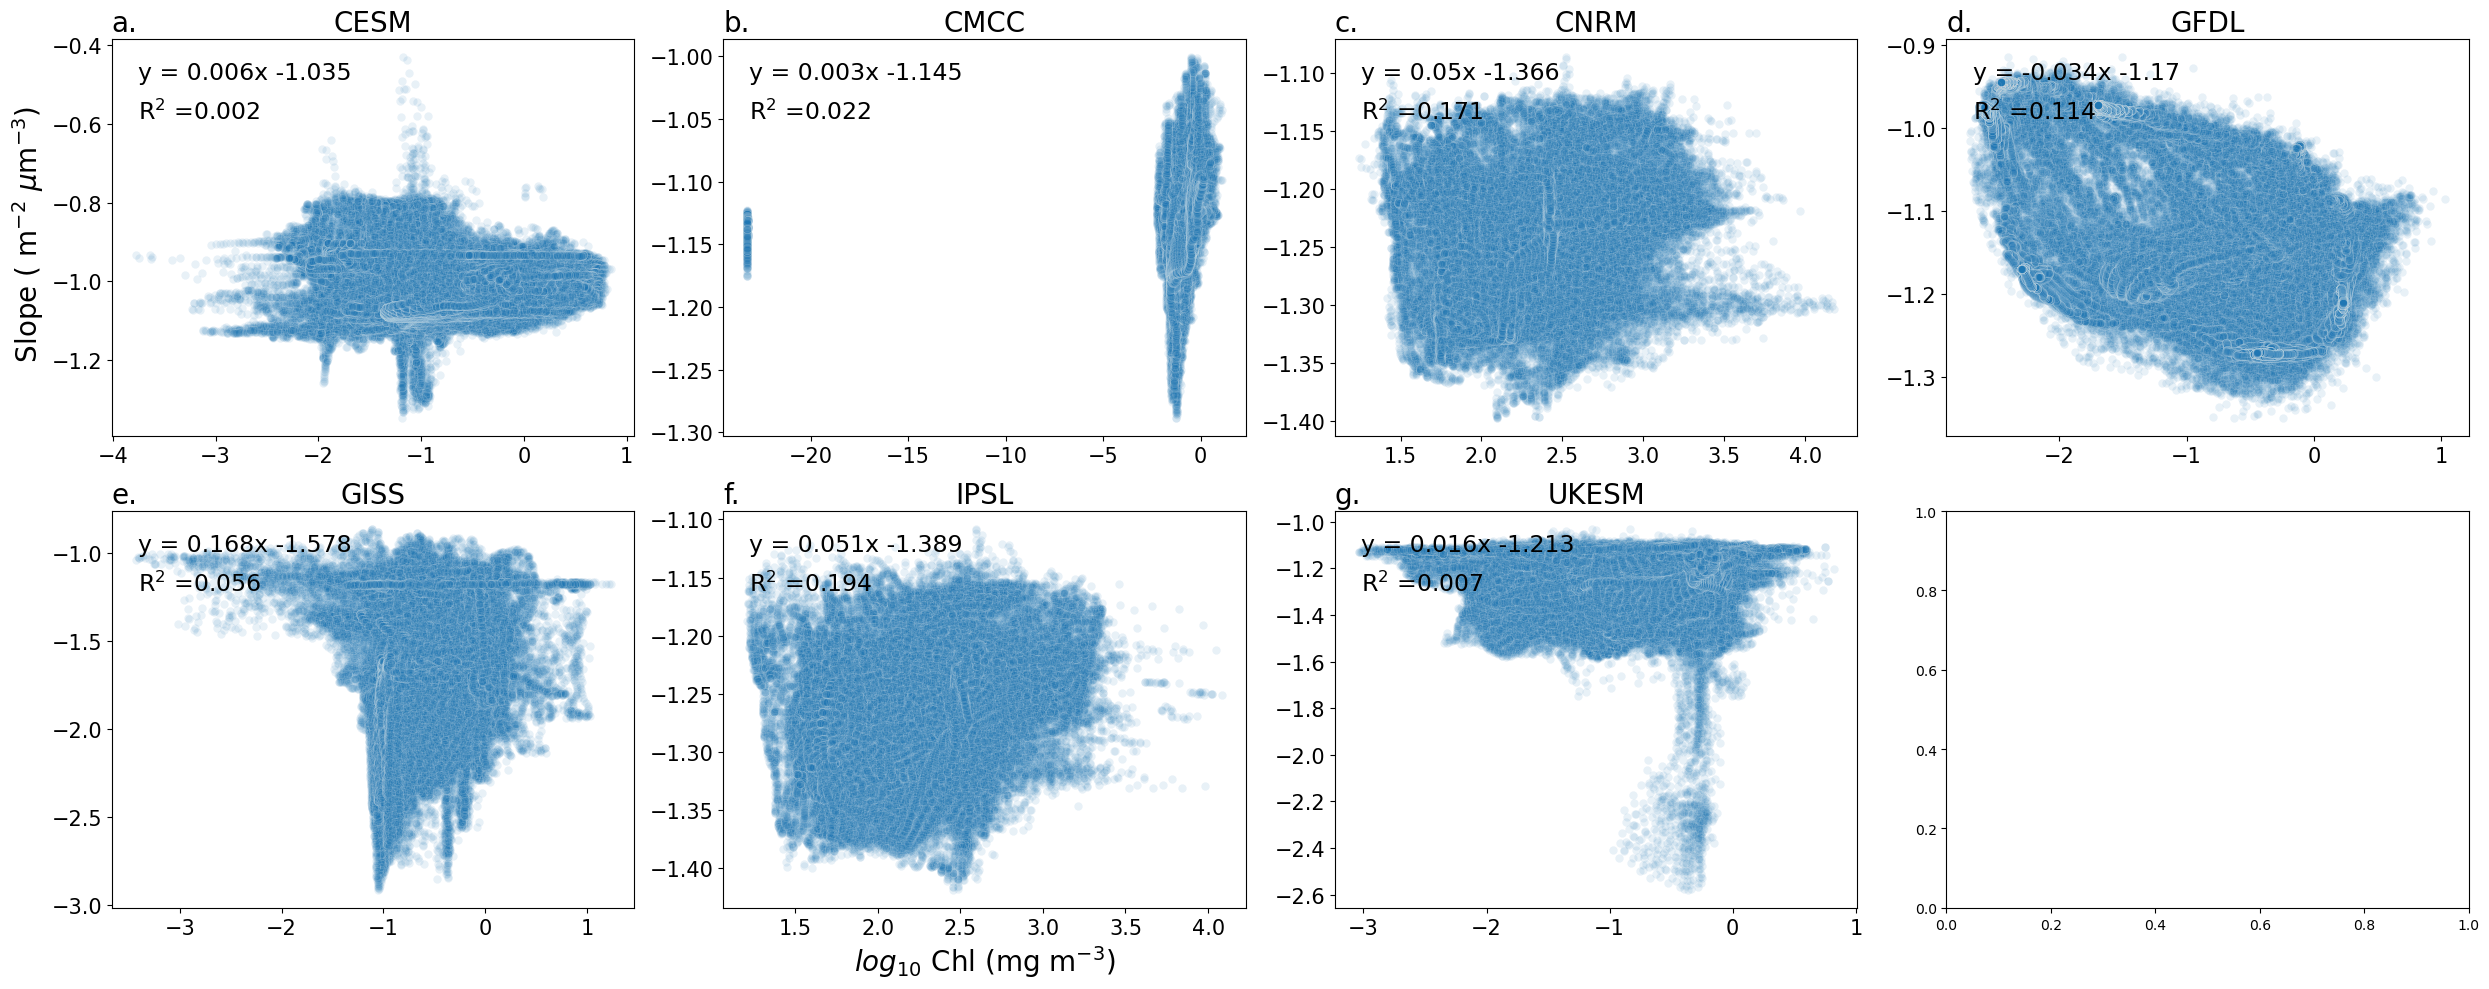

In [56]:
from matplotlib.ticker import MaxNLocator
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']
palette = dict(LC= 'cornflowerblue', HCSS= 'limegreen', HCPS= 'goldenrod')
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols = 4, figsize=(25,10))
variables = ['slope']
ind=0
for r, m in enumerate(model_list):
    #print(r)
    #print(c)
    ind +=1
    if m == 'CESM':
        ax_n = ax1
    if m == 'CMCC':
        ax_n = ax2
    if m == 'CNRM':
        ax_n = ax3
    if m == 'GFDL':
        ax_n = ax4
    if m == 'GISS':
        ax_n = ax5
    if m == 'IPSL':
        ax_n = ax6
    if m == 'UKESM':
        ax_n = ax7
    clim=sns.scatterplot(ax = ax_n,x = 'chl', y='slope', alpha=0.1, style_order=['hist','ssp5'], data=df[(df['source']== m) & (df['experiment']== 'hist')])
    ax_n.tick_params(axis='both', which='major', labelsize=15)
    ax_n.set_title(letters[ind-1], loc='left', fontsize=20)
    #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_n.set_title(m, fontsize=20)
    if r ==5:
        ax_n.set_xlabel('$log_{10}$ Chl (mg m$^{-3}$)', fontsize=20)
    else:
        ax_n.set_xlabel('', fontsize=20)
    if r ==0:
        ax_n.set_ylabel(r' Slope ( m$^{-2}$ $\mu$m$^{-3}$)', fontsize = 20)
    else:
        ax_n.set_ylabel('')
    if m == 'CESM':
        ax_n.annotate('y = '+str(np.round(CESM_reg.slope,3)) + 'x ' + str(np.round(CESM_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(CESM_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)

    if m == 'CMCC':
        ax_n.annotate('y = '+str(np.round(CMCC_reg.slope,3)) + 'x ' + str(np.round(CMCC_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(CMCC_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)

    if m == 'CNRM':
        ax_n.annotate('y = '+str(np.round(CNRM_reg.slope,3)) + 'x ' + str(np.round(CNRM_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(CNRM_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)

    if m == 'GFDL':
        ax_n.annotate('y = '+str(np.round(GFDL_reg.slope,3)) + 'x ' + str(np.round(GFDL_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(GFDL_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)

    if m == 'GISS':
        ax_n.annotate('y = '+str(np.round(GISS_reg.slope,3)) + 'x ' + str(np.round(GISS_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(GISS_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)

    if m == 'IPSL':
        ax_n.annotate('y = '+str(np.round(IPSL_reg.slope,3)) + 'x ' + str(np.round(IPSL_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(IPSL_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)
    if m == 'UKESM':
        ax_n.annotate('y = '+str(np.round(UKESM_reg.slope,3)) + 'x ' + str(np.round(UKESM_reg.intercept,3)), (0.05, 0.9), xycoords='axes fraction', size=17)
        ax_n.annotate(r'R$^{2}$ ='+str(np.round(UKESM_reg.rvalue**2,3)) , (0.05, 0.8), xycoords='axes fraction', size=17)
    
       

            
plt.tight_layout()
plt.savefig('/Users/mc4214/Documents/CMIP6_PSS_paper/figures/paper/newest/final_for_paper/figures_revised_Charlie/July_revision/fig_chl_slopes_all_cells_global.pdf', dpi=300)

In [8]:
from scipy.stats import linregress
source=[]
slope_all=[]
intercept_all=[]
r_all=[]
p_all=[]
st_err_all=[]
for m in model_list:
    for b in ['LC', 'HCSS', 'HCPS']:
        slope, intercept, r, p, st_err = linregress(x=df[(df['source']== m) & (df['biomes']== b) & (df['experiment']== 'hist')].chl,y=df[(df['source']== m) & (df['biomes']== b) & (df['experiment']== 'hist')].slope)
        source.append(m+'_'+b)
        slope_all.append(slope)
        intercept_all.append(intercept)
        r_all.append(r)
        p_all.append(p)
        st_err_all.append(st_err)

In [9]:
df_regress=pd.DataFrame()
df_regress['source']=source
df_regress['slope']=slope_all
df_regress['intercept']=intercept_all
df_regress['r']=r_all
df_regress['p']=p_all
df_regress['st_err']=st_err_all
df_regress['R2']=df_regress['r']**2
df_regress

source     slope  intercept         r              p    st_err  \
0      CESM_LC  0.007639  -1.068784  0.166749   0.000000e+00  0.000145   
1    CESM_HCSS       NaN        NaN       NaN            NaN       NaN   
2    CESM_HCPS  0.053239  -0.997295  0.335030   0.000000e+00  0.000748   
3      CMCC_LC  0.031685  -1.126284  0.299087   0.000000e+00  0.000258   
4    CMCC_HCSS  0.001290  -1.125197  0.101239  2.907666e-232  0.000040   
5    CMCC_HCPS -0.007733  -1.145020 -0.148878   5.229915e-45  0.000546   
6      CNRM_LC  0.018875  -1.328637  0.202408   0.000000e+00  0.000283   
7    CNRM_HCSS  0.011316  -1.255586  0.104537  1.802527e-287  0.000311   
8    CNRM_HCPS  0.020084  -1.279527  0.232603   0.000000e+00  0.000418   
9      GFDL_LC  0.023761  -1.146158  0.515442   0.000000e+00  0.000094   
10   GFDL_HCSS -0.062696  -1.164963 -0.584465   0.000000e+00  0.000169   
11   GFDL_HCPS  0.008810  -1.144650  0.183994   0.000000e+00  0.000217   
12     GISS_LC  0.007343  -1.821059  0.004683   1.656657e-01  0.005297   
13   GISS_HCSS  0.076787  -1.585208  0.112182   0.000000e+00  0.001879   
14   GISS_HCPS  0.091617  -1.566319  0.413089   0.000000e+00  0.001018   
15     IPSL_LC  0.016884  -1.343451  0.155619   0.000000e+00  0.000334   
16   IPSL_HCSS  0.020699  -1.298651  0.205264   0.000000e+00  0.000289   
17   IPSL_HCPS  0.019613  -1.314326  0.187038   0.000000e+00  0.000483   
18    UKESM_LC -0.029197  -1.318517 -0.104976  7.802299e-255  0.000854   
19  UKESM_HCSS -0.017690  -1.208210 -0.113666   0.000000e+00  0.000459   
20  UKESM_HCPS  0.001278  -1.172149  0.016144   3.738712e-05  0.000310   

          R2  
0   0.027805  
1        NaN  
2   0.112245  
3   0.089453  
4   0.010249  
5   0.022165  
6   0.040969  
7   0.010928  
8   0.054104  
9   0.265681  
10  0.341600  
11  0.033854  
12  0.000022  
13  0.012585  
14  0.170643  
15  0.024217  
16  0.042133  
17  0.034983  
18  0.011020  
19  0.012920  
20  0.000261

## try to do the trophic amplification thingy